In [1]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime
from scipy.fft import fft, fftfreq,rfft2
import scipy.signal as signal
from obspy.signal import filter as obsfilt

In [2]:
import glob
len(glob.glob("/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T233*"))

10

In [5]:
glob.glob("/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T231*")

['/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T231014Z.h5',
 '/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T231114Z.h5',
 '/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T231214Z.h5',
 '/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T231314Z.h5',
 '/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T231414Z.h5',
 '/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T231514Z.h5',
 '/d

In [3]:
# path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"
# file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T232914Z.npy"
# file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231"+str(i)+"14Z.h5"

f = h5py.File('/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5', 'r')
data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
f.close()

In [26]:
print('The spatial sampling interval is ',f['Acquisition'].attrs['SpatialSamplingInterval'],'m.')
print('The raw data unit is',f['Acquisition']['Raw[0]'].attrs['RawDataUnit'])
n = f['Acquisition']['Custom'].attrs['Fibre Refractive Index']
L = f['Acquisition'].attrs['GaugeLength']
print(n)
print(L)

The spatial sampling interval is  2.0419047 m.
The raw data unit is b'rad * 2PI/2^16'
1.4682
51.04762


In [23]:
f['Acquisition']['Custom'].attrs['Laser Wavelength (nm)']

1550

In [3]:
sliced_data = data[7500:12500,:]

In [6]:
# def gauss_lr(q):
#     return localreg(np.arange(size_val).reshape(-1,1).astype(np.float64),q, degree=0, weight_matr=weight_matr,ind_list=incl_list)


In [12]:
smoothed_dat = np.zeros(sliced_data.shape)
for i in tqdm(range(sliced_data.shape[1])):
    smoothed_dat[:,i] =gauss_lr(i)

100%|██████████| 12000/12000 [25:16<00:00,  7.91it/s]


In [13]:
np.save('/home/ldoyle/notebooks/rad_4_smooth_data/gaussian_smoothed_channels_7500_12500_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T233014Z.npy', smoothed_dat)


## Gaussian

In [2]:
def kernel(t):
    res = (1/np.sqrt(2*np.pi))*np.exp(-0.5*t**2)
    return res

In [3]:
radius = 10
size_val = 5000#sliced_data.shape[0]
x0 = np.arange(size_val).reshape(-1,1)

weight_matr = np.zeros((size_val,size_val))
incl_list = []
for i, xi in enumerate(x0):
    weight_matr[i,:] = kernel(np.linalg.norm(x0-xi[None,:], axis=1)/radius)

    incl_list.append( np.where(np.abs(weight_matr[i,:])>1e-10)[0])

In [7]:
def gauss_lr(q):
    return localreg(np.arange(size_val),sliced_data[:,q], degree=0, weight_matr=weight_matr,ind_list=incl_list)

In [ ]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"

for i in np.arange(4):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T233"+str(i+5)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    sliced_data = data[7500:12500,:]
    def gauss_lr(q):
        return localreg(np.arange(size_val),sliced_data[:,q], degree=0, weight_matr=weight_matr,ind_list=incl_list)
    smoothed_dat = np.zeros(sliced_data.shape)
    for i in tqdm(range(sliced_data.shape[1])):
        smoothed_dat[:,i] = gauss_lr(i)
    np.save('/home/ldoyle/notebooks/rad_10_smooth_data/gaussian_smoothed_channels_7500_12500_'+file[:-3]+'.npy', smoothed_dat)


 71%|███████▏  | 8569/12000 [19:49<07:59,  7.16it/s]

In [15]:
smoothed_dat = np.zeros(sliced_data.shape)
for i in tqdm(range(sliced_data.shape[1])):
    smoothed_dat[:,i] = gauss_lr(i)

 52%|█████▏    | 6221/12000 [21:05<11:33,  8.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 12000/12000 [32:38<00:00,  6.13it/s]


In [6]:
# np.save('/home/ldoyle/notebooks/rad_4_smooth_data/gaussian_smoothed_channels_7500_12500_'+file[:-3]+'.npy', smoothed_dat)
smoothed_dat = np.load('/home/ldoyle/notebooks/rad_10_smooth_data/gaussian_smoothed_channels_7500_12500_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T232514Z.npy')

In [7]:
smoothed_dat.shape

(5000, 12000)

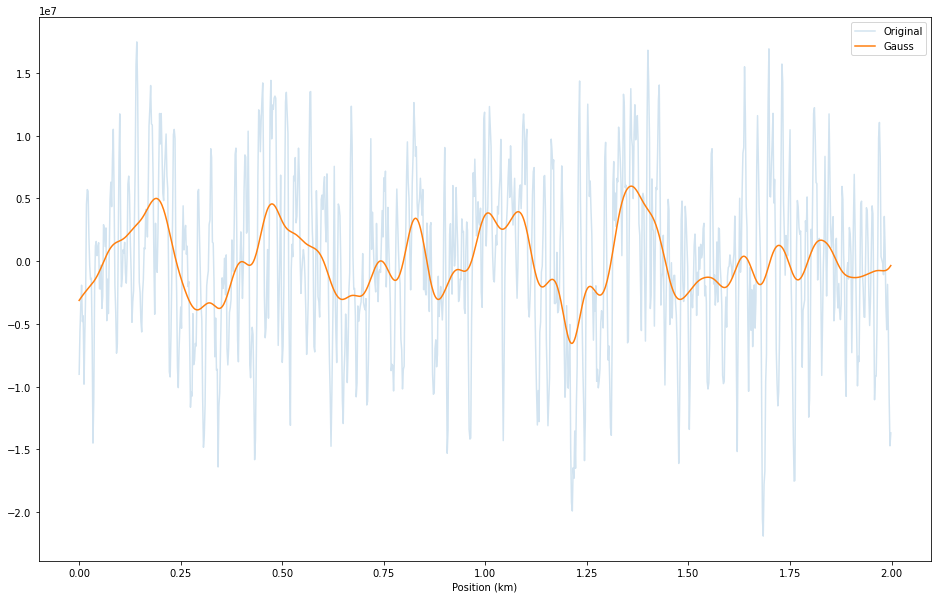

In [9]:
plt.figure(figsize=(16,10))
# plt.plot((2/1000)*np.arange(1000), lp_dat[740,:1000], label="BP Filt")
plt.plot((2/1000)*np.arange(1000), data[7500:8500,467], label="Original", alpha=0.2)
plt.plot((2/1000)*np.arange(1000), smoothed_dat[:1000,467],label="Gauss")
plt.legend()
plt.xlabel("Position (km)")
plt.show()

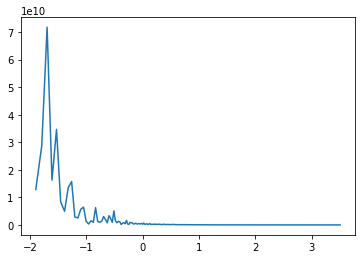

In [30]:
N=12000
yf1 = np.mean(fft(smoothed_dat),axis=0)
# yf3 = fft.rfft2(data[7500:12500,:])
xf = fftfreq(N, d=1/200)[1:N//2]
plt.figure()
plt.plot(np.log(xf)[8:-4000], 2.0/N *(np.abs(yf1[1:N//2])**2)[8:-4000])
#plt.xlim(0,0.2)
plt.show()


In [31]:
np.amax(2.0/N *(np.abs(yf1[1:N//2])**2)[8:-4000])

71730915097.91617

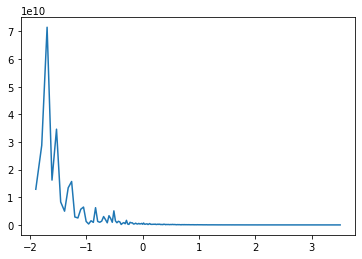

In [32]:
N=12000
yf1 = np.mean(fft(sliced_data),axis=0)
# yf3 = fft.rfft2(data[7500:12500,:])
xf = fftfreq(N, d=1/200)[1:N//2]
plt.figure()
plt.plot(np.log(xf)[8:-4000],2.0/N *(np.abs(yf1[1:N//2])**2)[8:-4000])
#plt.xlim(0,0.2)
plt.show()


In [33]:
np.amax(2.0/N *(np.abs(yf1[1:N//2])**2)[8:-4000])

71491612707.09859

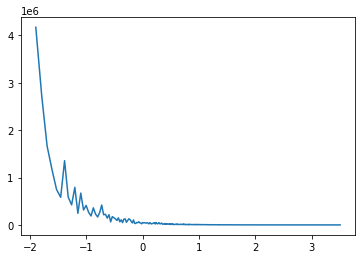

In [12]:
N=12000
yf1 = np.mean(fft(smoothed_dat),axis=0) - np.mean(fft(sliced_data),axis=0)
# yf3 = fft.rfft2(data[7500:12500,:])
xf = fftfreq(N, d=1/200)[1:N//2]
plt.figure()
plt.plot(np.log(xf)[8:-4000],2.0/N *(np.abs(yf1[1:N//2])**2)[8:-4000])
#plt.xlim(0,0.2)
plt.show()


In [18]:
np.amax(np.abs(yf1/np.mean(fft(smoothed_dat),axis=0)))

0.010996145937100073

In [20]:
import glob
file_list = glob.glob("/home/ldoyle/notebooks/rad_10_smooth_data/*")
n = 1.4682
L = 51.04762
working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*np.load(file_list[0])
#     "gaussian_smoothed_2021-11-01T231214Z_channels_7500_12500South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy") #full_dat[:,-48000:-24000]
working_dat = working_dat.T *10**6#/(np.std(working_dat))
mean_remove = (working_dat - np.mean(working_dat,axis=0)).T
# working_dat = mean_remove.reshape(mean_remove.shape[0],mean_remove.shape[1],1)

In [5]:
print(file_list[0])
print('South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5')

/home/ldoyle/notebooks/rad_10_smooth_data/gaussian_smoothed_channels_7500_12500_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy
South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5


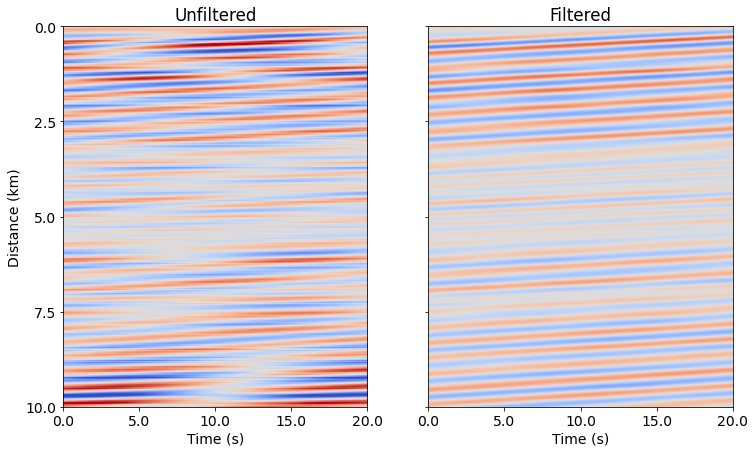

In [21]:
data2 = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*data[7500:12500,:]*1e6
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (12, 10),sharey=True)
ax[0].imshow(data2[:,4000:8000],vmin=-2,vmax=2,cmap="coolwarm")
ax[1].imshow(mean_remove[:,4000:8000],vmin=-2,vmax=2, cmap="coolwarm")

ax[0].set_yticks(np.linspace(0, 5000, 5),
            (2/1000)*np.linspace(0, 5000, 5))
ax[0].set_xticks(np.linspace(0,4000,5),(1/200)*np.linspace(0,4000,5))
ax[0].set_title('Unfiltered')
ax[0].set_xlabel("Time (s)",size=14)
ax[0].set_ylabel("Distance (km)",size=14)
ax[1].set_xticks(np.linspace(0,4000,5),(1/200)*np.linspace(0,4000,5))
ax[1].set_title('Filtered')
ax[1].set_xlabel("Time (s)",size=14)
plt.show()

In [3]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"

fileStr = "2021-11-01T2311_unfiltered"

init = 11
final= 16

time_subsample = 10
full_dat = np.zeros((5000,(12000//time_subsample)*(final-init)))

k = 0
for i in np.arange(init,final):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    
working_dat = full_dat/np.std(full_dat)

In [4]:
# f = h5py.File(path+file, 'r')
# f['Acquisition']['Raw[0]'].keys()

In [5]:
mean_remove = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy")[:,::10]
scaler_val = np.std(mean_remove)
mean_remove = mean_remove/scaler_val

In [6]:
smoothed_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/rad_4_smoothed_decimated_normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy")
scaler_val = np.std(smoothed_dat)
smoothed_dat = smoothed_dat/scaler_val

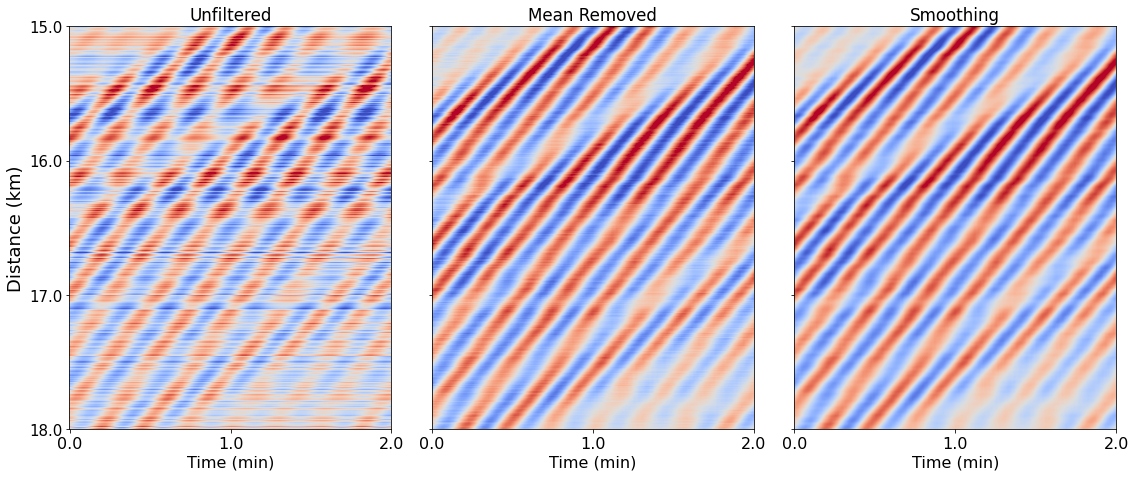

In [17]:
# data2 = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*data[7500:12500,:]*1e6
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=1, ncols=3,figsize = (16, 16),sharey=True)
ax[0].imshow(working_dat[:1500,:2400:2],vmin=-2.5,vmax=2.5,cmap="coolwarm")
ax[1].imshow(mean_remove[:1500,:2400:2],vmin=-2.5,vmax=2.5, cmap="coolwarm")
ax[2].imshow(smoothed_dat[:1500,:2400:2],vmin=-2.5,vmax=2.5, cmap="coolwarm")

ax[0].set_yticks(np.linspace(0, 1500, 4),
            (2./1000)*np.linspace(7500, 9000, 4), size=15)
ax[0].set_xticks(np.linspace(0,1200,3),np.linspace(0,2,3), size=16)
ax[0].set_title('Unfiltered')
ax[0].set_xlabel("Time (min)",size=16)
ax[0].set_ylabel("Distance (km)",size=18)
ax[1].set_xticks(np.linspace(0,1200,3),np.linspace(0,2,3), size=16)
ax[1].set_title('Mean Removed')
ax[1].set_xlabel("Time (min)",size=16)
ax[2].set_title('Smoothing')
ax[2].set_xlabel("Time (min)",size=16)
ax[2].set_xticks(np.linspace(0,1200,3),np.linspace(0,2,3), size=16)
plt.tight_layout()
plt.show()

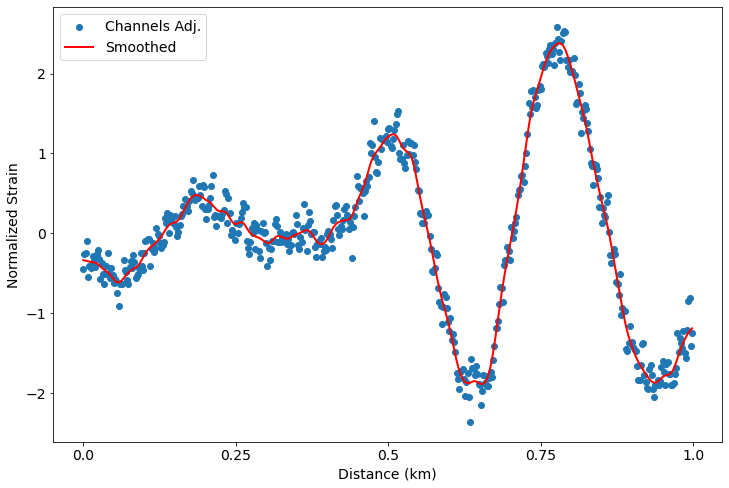

In [26]:
plt.figure(figsize=(12,8))
plt.scatter(np.arange(500),mean_remove[:500,54],label="Channels Adj.")
plt.plot(np.arange(500),smoothed_dat[:500,54], c="r",linewidth=2, label="Smoothed")
plt.xticks(np.linspace(0,500,5),(2/1000)*np.linspace(0,500,5))
plt.ylabel("Normalized Strain")
plt.xlabel("Distance (km)")
plt.legend()
plt.show()

In [11]:
mean_remove.shape

(5000, 12000)

## 5 Minute Segments (drift removed with linear least sq fit along channel)

In [11]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"

init = 11
final= 16

time_subsample = 1
full_dat = np.zeros((5000,(12000//time_subsample)*(final-init)))

k = 0
for i in np.arange(init,final):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    
working_dat = full_dat/np.std(full_dat)


In [12]:
A_channel = np.hstack((np.arange(working_dat.shape[1]).reshape((-1,1)),np.ones(working_dat.shape[1]).reshape((-1,1))))
coeffs = np.zeros((working_dat.shape[0],2))
for channel in range(working_dat.shape[0]):
    coeffs[channel,:] = np.linalg.lstsq(A_channel, working_dat[channel,:], rcond=None)[0]
    

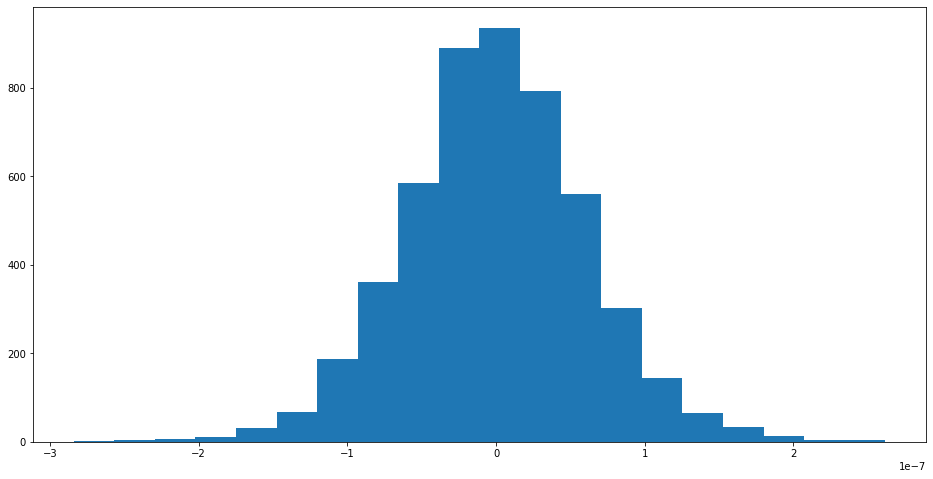

In [13]:
plt.figure(figsize=(16,8))
plt.hist(coeffs[:,0],bins=20)
plt.show()

In [14]:
drift_removal = np.zeros(full_dat.shape)
for channel in range(full_dat.shape[0]):
    drift_removal[channel,:] = working_dat[channel,:]-(coeffs[channel,0]*A_channel[:,0] + coeffs[channel,1])

In [15]:
np.save('/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T231114Z.npy',drift_removal)

In [42]:
drift_removal.shape

(5000, 60000)

In [19]:
working_dat = drift_removal.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])#*2.0419047

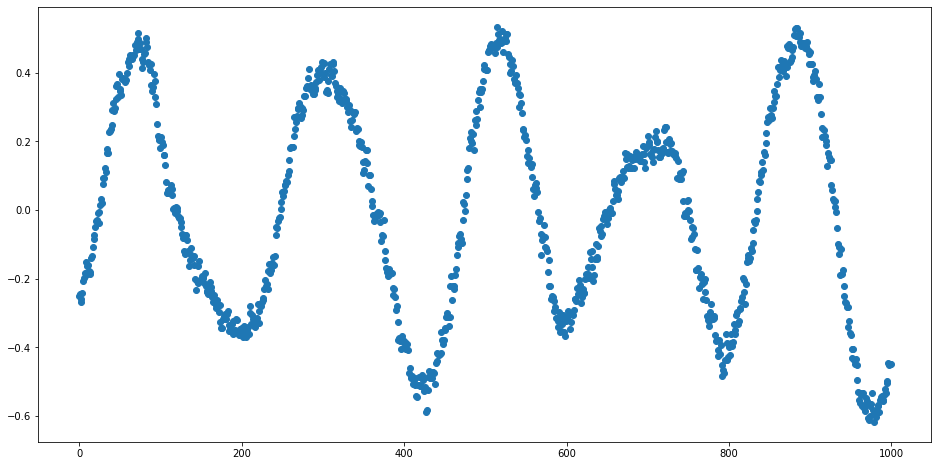

In [32]:
plt.figure(figsize=(16,8))
plt.scatter(np.arange(1000),drift_removal[:1000,1925])
# plt.scatter(np.arange(6000),drift_removal[78,:])

# plt.figure(figsize=(12,10))
# plt.imshow(drift_removal)
plt.show()

### Smooth corrected channels

In [2]:
starter_str = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231614Z"
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_"+starter_str+".npy")[:,::10]


In [3]:
def kernel(t):
    res = (1/np.sqrt(2*np.pi))*np.exp(-0.5*t**2)
    return res

In [4]:
radius = 4
size_val = 5000#sliced_data.shape[0]
x0 = np.arange(size_val).reshape(-1,1)

weight_matr = np.zeros((size_val,size_val))
incl_list = []
for i, xi in enumerate(x0):
    weight_matr[i,:] = kernel(np.linalg.norm(x0-xi[None,:], axis=1)/radius)

    incl_list.append( np.where(np.abs(weight_matr[i,:])>1e-10)[0])

In [5]:
def gauss_lr(q):
    return localreg(np.arange(size_val),working_dat[:,q], degree=0, weight_matr=weight_matr,ind_list=incl_list)

In [6]:
smoothed_dat = np.zeros(working_dat.shape)
for i in tqdm(range(working_dat.shape[1])):
    smoothed_dat[:,i] = gauss_lr(i)

100%|██████████| 6000/6000 [12:42<00:00,  7.87it/s]


In [7]:
np.save("/home/ldoyle/notebooks/channel_drift_5_min_clips/rad_4_smoothed_decimated_normalized_5_min_start_"+starter_str+".npy",smoothed_dat)

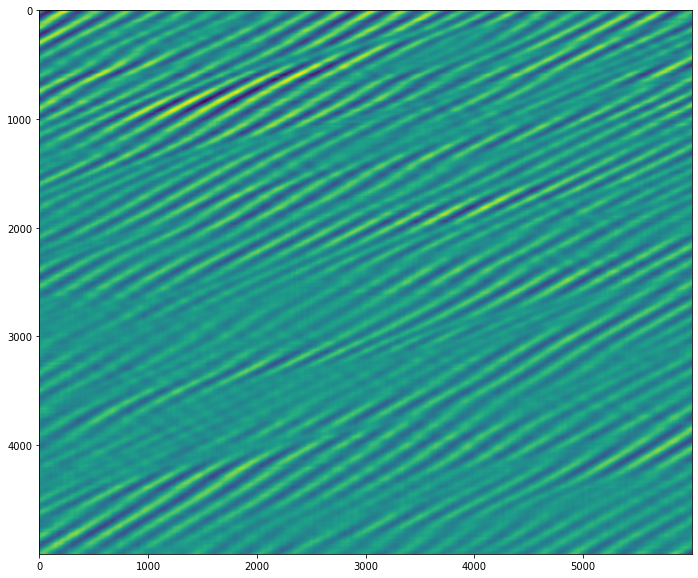

In [31]:
plt.figure(figsize=(12,10))
plt.imshow(smoothed_dat)#, vmax = 3.,vmin=-3.)
plt.show()

### Bandpass

In [2]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_11.npy")[:,::10]


In [48]:
# lp_dat = obsfilt.lowpass(working_dat.T, 8, 200, corners=1, zerophase=True)
lp_spat_dat = obsfilt.lowpass(working_dat, 0.001, 0.9, corners=4, zerophase=True)

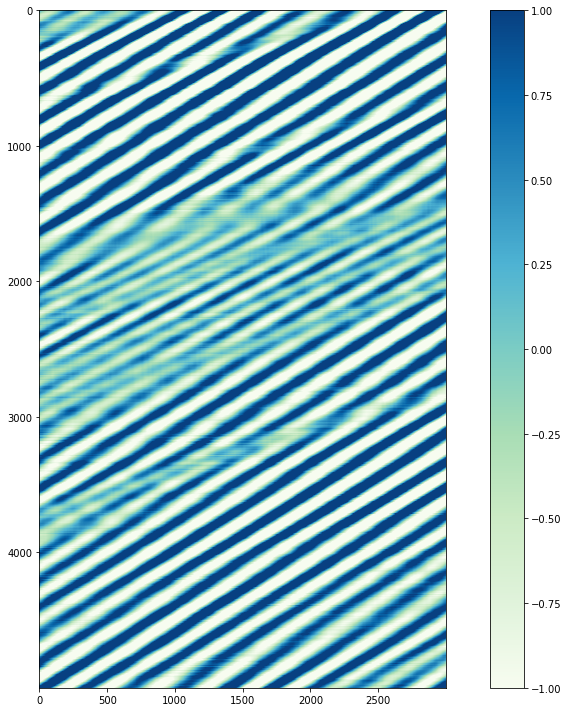

In [51]:
fig, (ax3) = plt.subplots(nrows=1, ncols=1, figsize = (16,10))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()

vmin=-1 #16478396

vmax = 1 #12709804

# im = ax1.imshow((working_dat[:,2000:3000]), vmin=vmin, vmax=vmax,
#                 cmap = 'GnBu')

# im2 = ax2.imshow((working_dat[:,:3000]-lp_spat_dat[:,:3000]), vmin=vmin, vmax=vmax,
#                 cmap = 'GnBu')

im3 = ax3.imshow((working_dat[:,:3000]-lp_spat_dat[:,:3000])/np.std(working_dat[:,:3000]), vmin=vmin, vmax=vmax,
                cmap = 'GnBu')
# plt.xlabel("Time", fontsize = 15)
# plt.ylabel("Channel", fontsize = 15)

# plt.colorbar(im2, ax = ax2, pad = 0.04)
plt.colorbar(im3, ax = ax3, pad = 0.04)

plt.show()

In [9]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/rad_4_smoothed_decimated_normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy")
working_dat_2 = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/rad_10_smoothed_decimated_normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy")

working_dat_1 = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy")


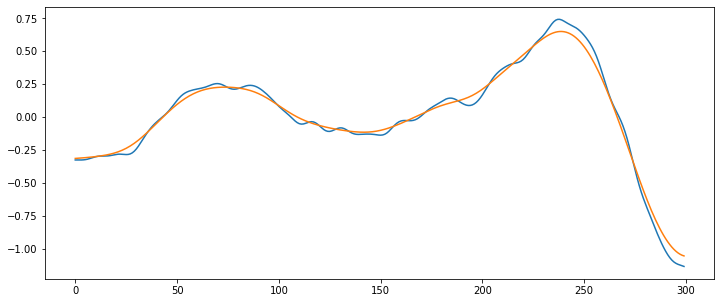

In [11]:
plt.figure(figsize=(12,5))
plt.plot(np.arange(300), working_dat[:300,89],label="Rad 4")
plt.plot(np.arange(300), working_dat_2[:300,89],label="Rad 10")
# plt.plot(np.arange(300), working_dat_1[:300,890],label="Flat")
plt.show()

In [17]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"

init = 11
final= 13

spatial_limit = 2500

spatial_subsample=10
time_subsample = 100
full_dat = np.zeros((5000,(12000//time_subsample)*(final-init)))

k = 0
for i in np.arange(init,final):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    
full_dat = full_dat[:spatial_limit:spatial_subsample,:(final-init)*int(12000/time_subsample)]

drft_rem = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy")[:spatial_limit:spatial_subsample,:(final-init)*12000:time_subsample]
smooth_rem = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/rad_4_smoothed_decimated_normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy")[:spatial_limit:spatial_subsample,:(final-init)*1200:int(time_subsample//10)]


In [18]:
full_dat = full_dat/np.std(full_dat)
drft_rem = drft_rem/np.std(drft_rem)
smooth_rem = smooth_rem/np.std(smooth_rem)

In [ ]:

fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(14,10))
for i in range(3):
    axs[i].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

axs[0].imshow(full_dat,cmap = "coolwarm",vmin=-4,vmax=4)
axs[0].set_title("Unfiltered",size=15)
axs[1].imshow(drft_rem,cmap = "coolwarm",vmin=-4,vmax=4)
axs[1].set_title("Channel Adjustment",size=15)

axs[2].imshow(smooth_rem,cmap = "coolwarm",vmin=-4,vmax=4)
axs[2].set_title("Channel Adj. + Smoothing",size=15)
plt.tight_layout(w_pad=1.)

fig.show()